$$f(H^{(l)}, A) = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)$$

```python
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

G = # какой-то граф на networkX в котором есть ноды, ребра и какие-то вектора признаков, ассоциированные с нодами
A = np.array(nx.attr_matrix(G, node_attr='name')[0]) # матрица смежностей
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis=1) # матричка признаков
AX = np.dot(A, X) # скалярное произведение

# Дот продукт - это сумма по соседним узлам. Не учитывает сам узел.
# Как предлагается решить эту проблему? А просто добавить петли для каждой ноды. Таким образом каждая нода начнет ссылаться сама на себя

G_self_loops = G.copy()
self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))
G_self_loops.add_edges_from(self_loops)
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0]) # матрица смежностей с петлями
AX = np.dot(A_hat, X) # скалярное произведение

# Надо нормировать
# Вчисляется матрица степеней (D) и выполняется операция скалярного произведения сконвертированной D с AX (DAX). «Степень» относится к количеству ребер, с которыми связан узел.
Deg_Mat = G_self_loops.degree() # степени
D = np.diag([deg for (n, deg) in list(Deg_Mat)]) # матрица степеней с самолупами
D_inv = np.linalg.inv(D) # обратная
DAX = np.dot(D_inv, AX) # скалярное произведение

# При таком подходе, чем ниже степень у узла, тем ближе он к какому-то кластеру узлов. Решение проблемы - трюк перенормировки.
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)

# Дальше просто: строится двухслойная сеть с прямым распространением. Четыре нейрона в первом слое. Два нейрона на выходе (два измеренеия). Relu


np.random.seed(77777)
n_h = 4 # число нейронов в скрытом слое
n_y = 2 # число нейронов на выходе
W0 = np.random.randn(X.shape[1], n_h) * 0.01
W1 = np.random.randn(n_h, n_y) * 0.01

# релу
def relu(x):
    return np.maximum(0, x)

# сеть
def gcn(A, H, W):
    I = np.identity(A.shape[0]) # диагональная матрица
    A_hat = A + I 
    D = np.diag(np.sum(A_hat, axis=0)) # матрица степеней
    D_half_norm = fractional_matrix_power(D, -0.5) # перенормировка
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)

# forward propagation
H1 = gcn(A, X, W0)
H2 = gcn(A, H1, W1)
```

 - **The new node features $H^{i}$ are not a function of its previous representation**: As you might have noticed, the aggregated representation of a node is only a function of its neighbours and does not include its own features. If not handled, this may lead to the loss of the node identity and hence rendering the feature representations useless. We can easily fix this by adding self loops, that is an edge starting and ending on the same node, in this way a node will become a neighbour of itself. Mathematically, self loops are nothing but can be expressed by adding the node identity 


 - **Degree of the nodes lead to the values being scaled asymmetricaly across the graph**: In simple words, nodes that have large number of neighbours (higher degree) will get much more input in the form of neighborhood aggregation from the adjacent nodes and hence will have a larger value and vice versa may be true for nodes with smaller degrees having small values. This can lead to problems during training the network. To deal with the issue, we will be using normalisation i.e, reduce all values in such a way that the values are on the same scale. Normalizing $A$ such that all rows sum to one, i.e. $D^{−1}A$, where $D$ is the diagonal node degree matrix, gets rid of this problem. Multiplying with $D^{−1}A$ now corresponds to taking the average of neighboring node features. According to the authors, after observing emperical results, they suggest "In practice, dynamics get more interesting when we use a symmetric normalization, i.e. $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$ (as this no longer amounts to mere averaging of neighboring nodes).
 
 
After addressing the two problems stated above, the new propagation function $f$ is:

$$f(H^{(l)}, A) = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)$$


where
 - $\hat{A} = A + I$
 - $I$ is the identity matrix
 - $\hat{D}$  is the diagonal node degree matrix of $\hat{A}$.

### Zachary Karate Club

During the period from 1970-1972, Wayne W. Zachary, observed the people belonging to a local karate club. He represented these people as nodes in a graph. And added a edge between a pair of people if they interacted with each other. The result was a the graph shown below.
![img](img/karate_club.png)

During the study an interesting event happened. A conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. 

Using the graph that he had found earlier, he tried to predict which member will go to which half. And surprisingly he was able to predict the decision of all the members except for node 9 who went with Mr. Hi instead of John A. Zachary used the maximum flow – minimum cut Ford–Fulkerson algorithm for this. We will be using a different algorithm today, hence it is not required to know about Ford-Fulkerson algorithm.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib notebook

import imageio
from celluloid import Camera
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

### The Convolutional Layer
First we will be creating the GCNConv class, which will serve as the Layer creation class. Every instance of this class will be getting Adjacency Matrix as input and will be outputing 'RELU(A_hat * X * W)', which the Net class will use.

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat = A + torch.eye(A.size(0))
        self.D = torch.diag(torch.sum(A, 1))
        self.D = self.D.inverse().sqrt()
        self.A_hat = torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W = nn.Parameter(torch.rand(in_channels, out_channels, requires_grad=True))
    
    def forward(self, X):
        out = torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out

The Net  class will combine multiple Conv layer.

In [3]:
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A, nfeat, nhid)
        self.conv2 = GCNConv(A, nhid, nout)
        
    def forward(self,X):
        H  = self.conv1(X)
        H2 = self.conv2(H)
        return H2

In [4]:
# 'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])

In this example we have the label for admin(node 1) and instructor(node 34) so only these two contain the class label(0 and 1) all other are set to -1, which means that the predicted value of these nodes will be ignores in the computation of loss function.

In [5]:
target = torch.tensor([0,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1, -1, 1])

X is the feature matrix. Since we dont have any feature of each node, we will just be using the one-hot encoding corresponding to the index of the node.

In [6]:
X = torch.eye(A.size(0))

Here we are creating a Network with 10 features in the hidden layer and 2 in output layer.

In [7]:
T = Net(A,X.size(0), 10, 2)

### Training

In [8]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.01, momentum=0.9)

In [9]:
loss = criterion(T(X), target)

<IPython.core.display.Javascript object>


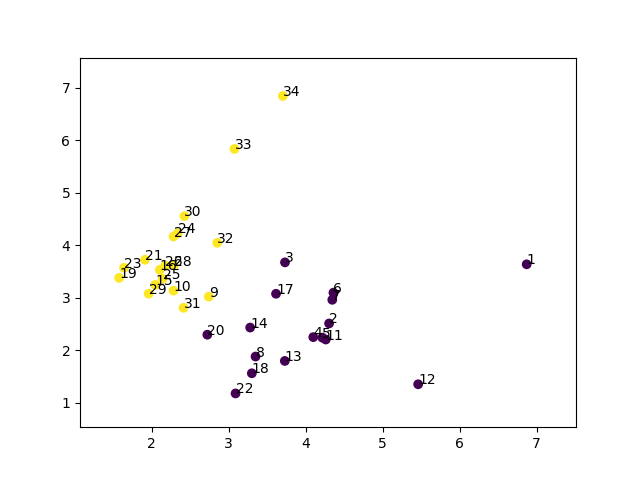

In [10]:
# Plot animation using celluloid
fig = plt.figure()
camera = Camera(fig)

for i in range(200):
    optimizer.zero_grad()
    loss = criterion(T(X), target)
    loss.backward()
    optimizer.step()
    l = (T(X));

    plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=[0, 0, 0, 0 ,0 ,0 ,0, 0, 1, 1, 0 ,0, 0, 0, 1 ,1 ,0 ,0 ,1, 0, 1, 0 ,1 ,1, 1, 1, 1 ,1 ,1, 1, 1, 1, 1, 1 ])
    for i in range(l.shape[0]):
        text_plot = plt.text(l[i,0], l[i,1], str(i+1))

    camera.snap()

    if i%20==0:
        print("Cross Entropy Loss: =", loss.item())

animation = camera.animate(blit=False, interval=150)
animation.save('img/train_karate_animation.mp4', writer='ffmpeg', fps=60)
HTML(animation.to_html5_video())